 <h1><center> Project: Tweet Phrase Extraction and Prediction </center></h1>
 <h1><center> Instructor: Dr. Marco Montes de Oca</center></h1>
 <h1><center> Date: 6/26/2020</center></h1>
 <h1><center> Team Members: Priyanka Adiga, Anubhav Saha</h1>

 <br>

<h2> Introduction </h2>

<p> &emsp;&emsp; Today we see many tweets circulating over Twitter feeds. With so many tweets circulating, at times it becomes difficult to determine whether the sentiment behind a specific tweet by a user will positively impact a company, or a person's brand for being viral (positive), or negatively impact the company by losing the shareholder confidence because it strikes a negative tone. Thus, it is important to understand the sentiment behind a certain message or a tweet. In this project we have decided to analyze these tweets for their sentiments. The tweets are classified into three labels namely positive, negative, and neutral and we have to analyze the tweet and determine the phrase or the word that is responsible for the associated sentiment label. The dataset on which we will be performing this predictive analysis on is retrieved from one of the featured Active Kaggle competitions. [3] </p>

<p> &emsp;&emsp; The tweet sentiment extraction dataset consists of four columns, namely text ID, text, sentiment, and lastly selected text. Each row of the dataset consists of text of a tweet and an associated sentiment label. Furthermore, in the training dataset we are provided with a word or a phrase that is drawn from the tweet itself, named ‘selected text’ that encapsulates the sentiment provided. The description of each of these columns is as given below. 
Text ID -An unique ID, that identified each piece of text
text - the text description or the text of the tweet
sentiment - the general sentiment of the tweet
selected_text - the text that supports the tweet's sentiment(this attribute is available in train data set alone)
.</p>


### Analysis

To begin with, we will import all the necessary libraries required for processing the data, performing EDA and building the predictive model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # for creating, changing and obtaining directories
import re # for regular expressions
import string
import matplotlib.pyplot as plt
#import matplotlib_venn as venn
import seaborn as sns


from tqdm import tqdm # tqdm is used to show the progress bar during model training and SpaCy is used for building the model
import spacy # SpaCy is used to train the model
import random
from spacy.util import compounding
from spacy.util import minibatch
from collections import defaultdict
from collections import  Counter


# sklearn 
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

#nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
stop=set(stopwords.words('english'))
#pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

#Avoid warning messages
import warnings
warnings.filterwarnings("ignore")

#plotly libraries. pip install plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
#import cufflinks
#cufflinks.go_offline()
#cufflinks.set_config_file(world_readable=True, theme='pearl')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# change the current working directory to a directory where you have your data files

os.chdir('D:\ALY6020 81941 Predictive Analytics SEC 03 Spring 2020 CPS [VTC-B-HY] ALY6020.81941.202035\Project')

In [3]:
# validating the change of directory

cwd = os.getcwd()
cwd

'D:\\ALY6020 81941 Predictive Analytics SEC 03 Spring 2020 CPS [VTC-B-HY] ALY6020.81941.202035\\Project'

In [9]:
#importing the text dataset in the form of dataframes

tweet_train = pd.read_csv("train.csv")
tweet_test = pd.read_csv("test.csv")
tweet_submission = pd.read_csv("sample_submission.csv")


In [10]:
#determining the shape of the data

print("Shape of Training Set:",tweet_train.shape)
print("Shape of Test Set:",tweet_test.shape)

Shape of Training Set: (27481, 4)
Shape of Test Set: (3534, 3)


As we can see in the above snapshot, the training set consists of 27481 rows and 4 columns. The test set consists of 3534 rows and 3 columns. 

In [11]:
#extracting information about training data

tweet_train.dropna(inplace=True)
tweet_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
textID           27480 non-null object
text             27480 non-null object
selected_text    27480 non-null object
sentiment        27480 non-null object
dtypes: object(4)
memory usage: 1.0+ MB


After dropping the NAs, the size of the training dataset reduced only by 1, indicating the dataset had only 1 NA.

In [12]:
#extracting information about test data

tweet_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
textID       3534 non-null object
text         3534 non-null object
sentiment    3534 non-null object
dtypes: object(3)
memory usage: 83.0+ KB


In [13]:
# Taking a glimpse of the training dataset

tweet_train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [14]:
# Taking a glimpse of the test dataset

tweet_test.head()

textID                                               text sentiment
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive
2  eee518ae67  Recession hit Veronique Branquinho, she has to...  negative
3  01082688c6                                        happy bday!  positive
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive

In [15]:
#Getting a summary of the train dataset

tweet_train.describe()

textID                 text selected_text sentiment
count        27480                27480         27480     27480
unique       27480                27480         22463         3
top     1563230736  Is at a photoshoot.          good   neutral
freq             1                    1           199     11117

In [16]:
#Getting a summary of the test dataset

tweet_test.describe()

textID                                         text sentiment
count         3534                                         3534      3534
unique        3534                                         3534         3
top     bad6311330  i really wanna go to australia and england.   neutral
freq             1                                            1      1430

In [17]:
#Looking at the distrubution of the dataset

dist_train = tweet_train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
dist_train.style.background_gradient(cmap='Blues')

Text(0.5, 1.0, 'Count of Test class labels')

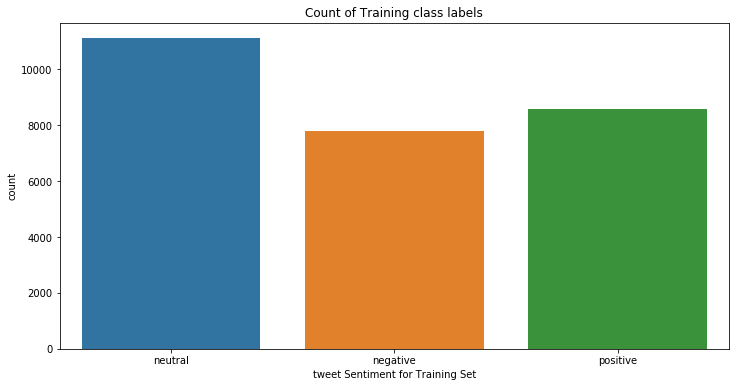

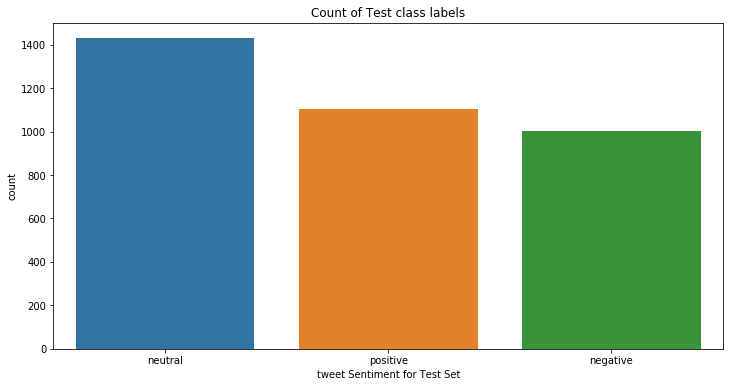

In [18]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=tweet_train)
plt.xlabel('tweet Sentiment for Training Set')
plt.title('Count of Training class labels')

plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=tweet_test)
plt.xlabel('tweet Sentiment for Test Set')
plt.title('Count of Test class labels')


### EDA on Selected text

<p> &emsp;&emsp; We will undergo some basic text prepocessing and EDA on our target field- Selected Text.This is to understand how this feature is distributed in train data.</p>

<p>Find URLs<br>
Punctuations<br>
Length of tweets<br>
Average of tweets<br>
Most words<br></p>

<p>Why to consider URL?</p>
<p>URLs makes no sense for extreme sentiments.There are chances that they stay on neutral side.Lets check how they are spread in selected text</p>

In [18]:
#converting text in sentiment to lower
tweet_train['target']=tweet_train['selected_text'].str.lower()


#finding the URL in sentiment
def find_URL(string): 
    url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', string)
    return "".join(url) 
tweet_train['target_url']=tweet_train['target'].apply(lambda x: find_URL(x))
df=pd.DataFrame(tweet_train.loc[tweet_train['target_url']!=""]['sentiment'].value_counts()).reset_index()
df.rename(columns={"index": "sentiment", "sentiment": "url_count"})

sentiment  url_count
0   neutral        345
1  positive          3
2  negative          3

<p> Observation:</p>


<p>As expected,our target variables that has urls are neutral tweets.Only few urls are found in positive and negative.
Our model would easily judge that if the text has URL it will be along neutral side.</p>


<p> Punctuations - Selected Text:</p>

<p>Can punctutations/symbols play a part in modelling?
Since we are analysing sentimental tweets,people describe their emotions in symbols.Say symbols like continuous stars ( * ) is considered to be extreme emotions(happy,angry,delight etc).Other symbols like (# - tagging) or (@ - mention) are also used very often in tweets.</p>

<p>Lets analyse all of them including other punctuations</p>


In [19]:
# Function to find punctuation in sentiment
def find_punctuation(text):
    line = re.findall(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', text)
    string="".join(line)
    return list(string)

# New Features with punctuation and punctuation length
tweet_train['target_punct']=tweet_train['target'].apply(lambda x:find_punctuation(x))
tweet_train['target_punct_len']=tweet_train['target'].apply(lambda x:len(find_punctuation(x)))

In [20]:
p_df=pd.DataFrame(tweet_train,columns=['target_punct','sentiment'])
p_df=p_df[p_df['target_punct'].map(lambda d: len(d)) > 0]
p_df=p_df.explode('target_punct')

positiveDf=pd.DataFrame(p_df.loc[p_df['sentiment']=="positive"]['target_punct'].value_counts()).reset_index().rename(columns={'index': 'punctuation','target_punct':'pos_punct'})
negativeDf=pd.DataFrame(p_df.loc[p_df['sentiment']=="negative"]['target_punct'].value_counts()).reset_index().rename(columns={'index': 'punctuation','target_punct':'neg_punct'})
neutralDf=pd.DataFrame(p_df.loc[p_df['sentiment']=="neutral"]['target_punct'].value_counts()).reset_index().rename(columns={'index': 'punctuation','target_punct':'neut_punct'})

In [21]:
fig = make_subplots(rows=1, cols=3)

fig.append_trace(go.Bar(x=positiveDf.punctuation[:10],y=positiveDf.pos_punct[:10],name='Positive',marker_color='green'), row=1, col=1)
fig.append_trace(go.Bar(x=negativeDf.punctuation[:10],y=negativeDf.neg_punct[:10],name='Negative',marker_color='red'), row=1, col=2)
fig.append_trace(go.Bar(x=neutralDf.punctuation[:10],y=neutralDf.neut_punct[:10],name='Neutral',marker_color='blue'), row=1, col=3)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text="Selected Text -Punctuations in different sentiments",title_x=0.5)
fig.show()

Impact of * in the sentiment

In [22]:
#function to determine '*' symbol
def find_starSymbol(text):
   # if len(text.split())<1:
    line=re.findall(r'[*]{2,5}',text)
    return len(line)

tweet_train['star']=tweet_train['target'].apply(lambda x:find_starSymbol(x))
tweet_train.loc[tweet_train['star']!=0]['sentiment'].value_counts().to_frame()

sentiment
negative        317
neutral         248
positive         50

Eventhough negative shows high counts.Still it describes about neutral tweets dependency.Let us analyse the tweet with only ( * ) in tweet.

In [23]:
#function to determine only * symbols
def find_starSymbol_only(text):
    if len(text.split())==1:
        line=re.findall(r'[*]{2,5}',text)
        return len(line)
    else:
        return 0
    
    
#get column values that has only * in its tweet
tweet_train['only_star']=tweet_train['target'].apply(lambda x:find_starSymbol_only(x))
tweet_train.loc[tweet_train['only_star']==1]['sentiment'].value_counts()    

negative    96
Name: sentiment, dtype: int64

Impact of ! in the tweet

In [24]:
#function to determine ! in the tweet
def find_exclamatorySymbol(text):
   # if len(text.split())<1:
    line=re.findall(r'[!]',text)
    return len(line)

tweet_train['exclaim']=tweet_train['target'].apply(lambda x:find_exclamatorySymbol(x))
tweet_train.loc[tweet_train['exclaim']!=0]['sentiment'].value_counts().to_frame()

sentiment
neutral        2636
positive       1512
negative        820

Observation:

All sentiment tweets have full stop and quotes on top of list which is expected.
Tweets with ( * ) only has negative sentiments
( # ) and ( @ ) are no where in top lists.

Length - Selected Text

In this section we will analyse more on words of selected_text. Before extracting length of selected_text words,let us remove urls and punctuation

Note: We need to keep in mind that while modelling we cant strip them.They play part in jaccard score.Now we will do this check the distribution of words only.

In [25]:
#function to remove URL

def remove_URL(string): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'," ",string)
    return " ".join(text.split())


#function to remove punctuation
def remove_punctuation(text):
    line = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]+'," ",text)
    return " ".join(line.split())

In [26]:
#removing uRL and punctuation from target

tweet_train['target']=tweet_train['target'].apply(lambda x:remove_URL(x))
tweet_train['target']=tweet_train['target'].apply(lambda x:remove_punctuation(x))


tweet_train['targetTweet_length']=tweet_train['target'].str.split().map(lambda x: len(x))
tweet_train['targetTweet_length'].describe().to_frame()

targetTweet_length
count        27480.000000
mean             7.278785
std              7.099577
min              0.000000
25%              1.000000
50%              5.000000
75%             11.000000
max             35.000000

In [44]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=tweet_train[tweet_train['sentiment']=='positive']['targetTweet_length'],name="Positive",marker_color='#7cfc00'))
fig.add_trace(go.Histogram(x=tweet_train[tweet_train['sentiment']=='negative']['targetTweet_length'],name="Negative",marker_color='red'))
fig.add_trace(go.Histogram(x=tweet_train[tweet_train['sentiment']=='neutral']['targetTweet_length'],name="Neutral",marker_color='blue'))

# Overlay both histograms

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(
    title_text='Length of Selected tweet', # title of plot
    xaxis_title_text='Length', # xaxis label
    yaxis_title_text='Count', # yaxis label
    title_x=0.5,
    barmode='overlay'
)

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)

fig.show()



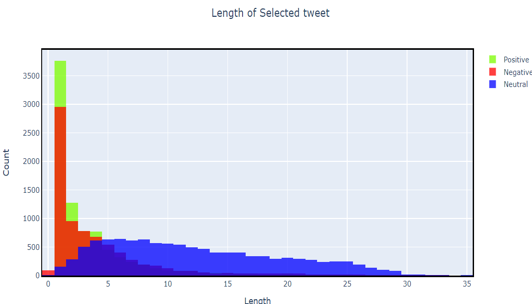

Observation:

Average length of word in selected text is around 7 which seems bit high.This says we need to predict more words per tweet
Most of positive and negative tweets have selected text length less than 5.This is good significance as we can add exclude conditons for predicting words.
Neutral sentiments are distributed across all length

Average Length - Selected Text

Averaging selected text can determine us how long the train data has accepted strings from whole tweet.We will find the distribution of the selected text or target variable

In [28]:
#determining average word length
tweet_train['target_Average_wordlength']=tweet_train['target'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
tweet_train['target_Average_wordlength'].describe().to_frame()

target_Average_wordlength
count               27385.000000
mean                    4.335601
std                     1.709255
min                     1.000000
25%                     3.428571
50%                     4.000000
75%                     4.888889
max                   110.000000

In [29]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=tweet_train[tweet_train['sentiment']=='positive']['target_Average_wordlength'], xbins=dict(
        start=1,
        end=30,
        size=1
    ),name="Positive",marker_color='green'))
fig.add_trace(go.Histogram(x=tweet_train[tweet_train['sentiment']=='negative']['target_Average_wordlength'], xbins=dict(
        start=1,
        end=30,
        size=1
    ),name="Negative",marker_color='red'))
fig.add_trace(go.Histogram(x=tweet_train[tweet_train['sentiment']=='neutral']['target_Average_wordlength'], xbins=dict(
        start=1,
        end=30,
        size=1
    ),name="Neutral",marker_color='blue'))

# Overlay both histograms
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(
    title_text='Target - Average length of Selected Text', # title of plot
    xaxis_title_text='Length', # xaxis label
    yaxis_title_text='Count', # yaxis label
    title_x=0.5,
    barmode='overlay'
)

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.70)
fig.show()

Observation:

Positive and negative are averaging around 4-5 per sentence
Neutral keeps their high density.

Most Words - Selected Text

This is essential to know before we perform modelling.Before we perform GLOVE or any word embedding,it is good to know which all are the words often used.

In [30]:
#function to create corpus
def create_Tweetcorpus(data,feature,sentiment):
    corpus=[]
    for x in data[data['sentiment']==sentiment][feature].str.split():
        for i in x:
            corpus.append(i)
    return corpus

#sentiment
def corpus_Tweetsentiment(data,feature,sentiment):
    corpus=create_Tweetcorpus(data,feature,sentiment)
    dic=defaultdict(int)
    for word in corpus:
        if word not in stop:
            dic[word]+=1
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)
    x,y=zip(*top)
    return x,y



In [31]:
y=list(corpus_Tweetsentiment(tweet_train,'target','positive')[1][:15])
y

[831, 733, 701, 468, 444, 364, 289, 267, 248, 235, 182, 167, 157, 155, 155]

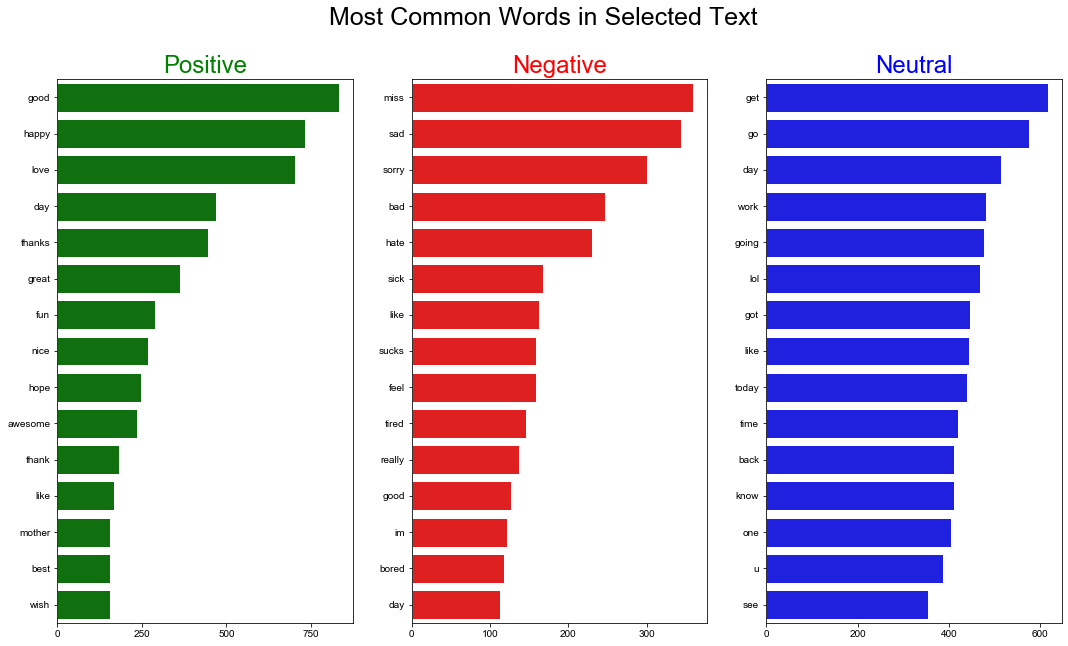

In [32]:
f, axes = plt.subplots(1,3,figsize=(18,10))
sns.set(font_scale =2)
sns.barplot(y=list(corpus_Tweetsentiment(tweet_train,'target','positive')[0])[:15], x= list(corpus_Tweetsentiment(tweet_train,'target','positive')[1])[:15],color="green",ax=axes[0]).set_title("Positive",color="green")
sns.barplot(y=list(corpus_Tweetsentiment(tweet_train,'target','negative')[0])[:15], x=list(corpus_Tweetsentiment(tweet_train,'target','negative')[1])[:15],color="red", ax=axes[1]).set_title("Negative",color="red")
sns.barplot(y=list(corpus_Tweetsentiment(tweet_train,'target','neutral')[0])[:15], x=list(corpus_Tweetsentiment(tweet_train,'target','neutral')[1])[:15],color="blue", ax=axes[2]).set_title("Neutral",color="blue")

plt.suptitle("Most Common Words in Selected Text" ,fontsize=25,color="black")
plt.show() 

Observation:

Positive produces words like good,happy,thanks which is quite expected
Negative produces words like miss,sad,sorry,bad which indicates negative emotions
Neutral produces words like get,going,work which is sort of common words
We could see "day" comes in all three sentiments.(These tweets might be indicating a event day.Hopefully we may come to know after competition)

In [33]:
TrainTest_data = pd.concat([tweet_train,tweet_test])
TrainTest_data['text']=TrainTest_data['text'].str.lower()
TrainTest_data.shape


(31014, 13)

In [34]:
tweet_train_word=TrainTest_data[:tweet_train.shape[0]]
tweet_test_word=TrainTest_data[tweet_test.shape[0]:]

In [35]:
#function for N-gram of (N)grams - Train Selected text
def N_grams_plot(corpus,ngram_range,n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english',ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df

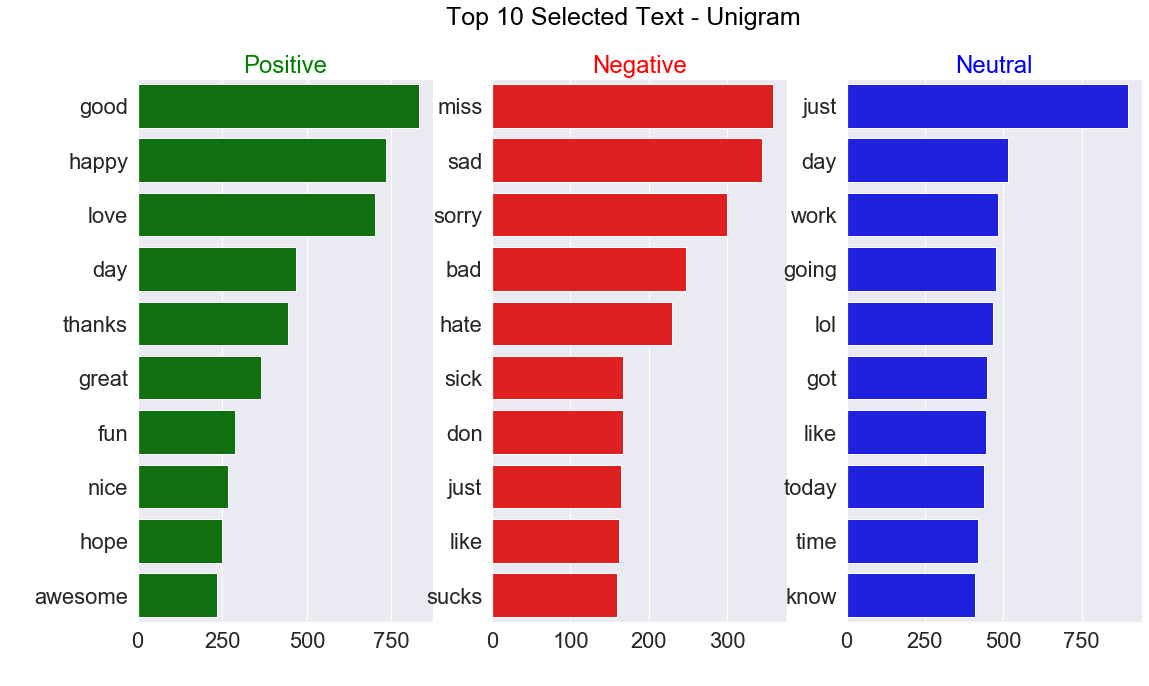

In [36]:
f, axes = plt.subplots(1,3,figsize=(18,10))
sns.set(font_scale =2)
sns.barplot(y=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='positive']['target'],(1,1),10)['text'],
            x= N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='positive']['target'],(1,1),10)['count'],
            color="green",ax=axes[0]).set_title("Positive",color="green")
axes[0].set(ylabel=" ",xlabel=" ")
sns.barplot(y=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='negative']['target'],(1,1),10)['text'],
            x=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='negative']['target'],(1,1),10)['count'],
            color="red", ax=axes[1]).set_title("Negative",color="red")
axes[1].set(ylabel=" ",xlabel=" ")
sns.barplot(y=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='neutral']['target'],(1,1),10)['text'], 
            x=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='neutral']['target'],(1,1),10)['count'],
            color="blue", ax=axes[2]).set_title("Neutral",color="blue")
axes[2].set(ylabel=" ",xlabel=" ")
f.suptitle("Top 10 Selected Text - Unigram" ,fontsize=25,color="black")
f.show() 





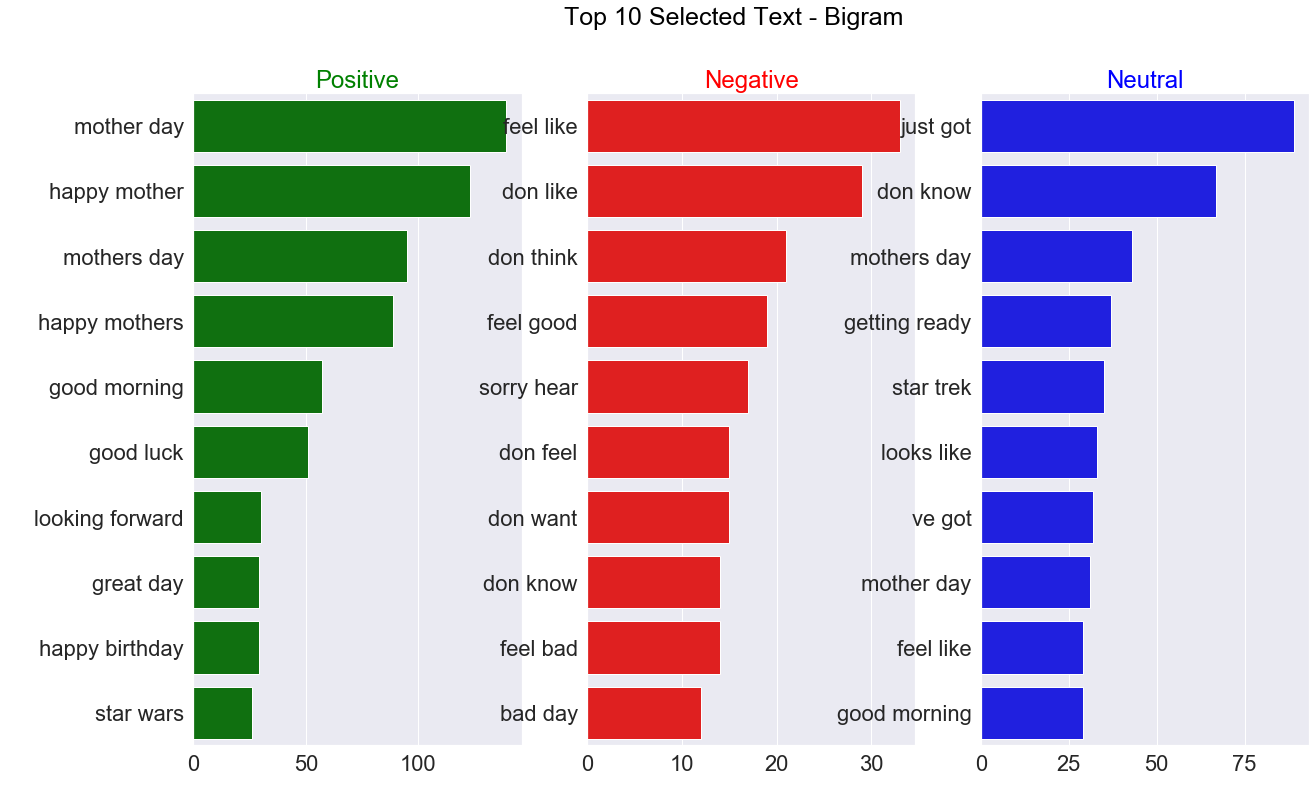

In [37]:
f, axes = plt.subplots(1,3,figsize=(20,12))
sns.set(font_scale =2)
sns.barplot(y=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='positive']['target'],(2,2),10)['text'],
            x= N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='positive']['target'],(2,2),10)['count'],
            color="green",ax=axes[0]).set_title("Positive",color="green")
axes[0].set(ylabel=" ",xlabel=" ")
sns.barplot(y=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='negative']['target'],(2,2),10)['text'],
            x=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='negative']['target'],(2,2),10)['count'],
            color="red", ax=axes[1]).set_title("Negative",color="red")
axes[1].set(ylabel=" ",xlabel=" ")
sns.barplot(y=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='neutral']['target'],(2,2),10)['text'], 
            x=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='neutral']['target'],(2,2),10)['count'],
            color="blue", ax=axes[2]).set_title("Neutral",color="blue")
axes[2].set(ylabel=" ",xlabel=" ")
f.suptitle("Top 10 Selected Text - Bigram" ,fontsize=25,color="black")
f.show() 


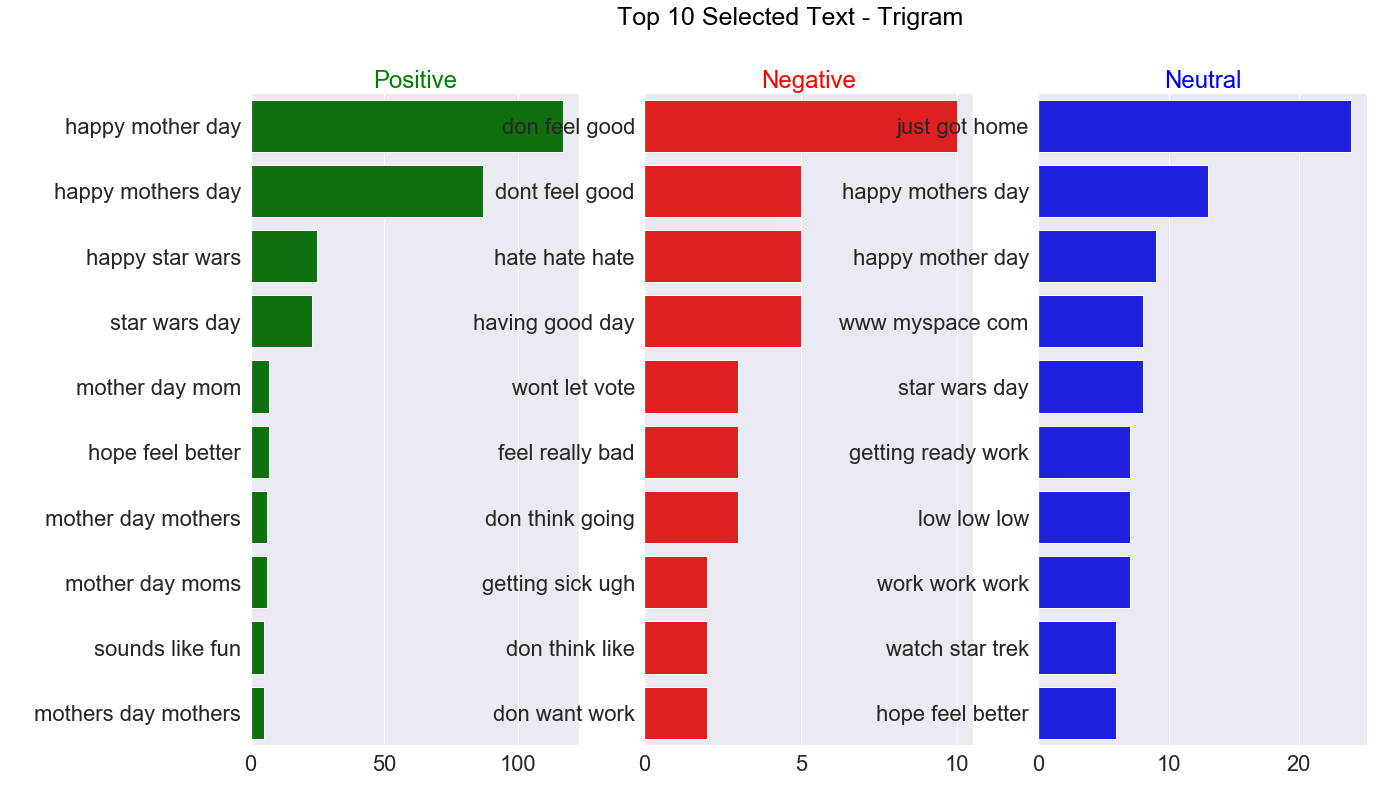

In [38]:
f, axes = plt.subplots(1,3,figsize=(20,12))
sns.set(font_scale =2)
sns.barplot(y=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='positive']['target'],(3,3),10)['text'],
            x= N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='positive']['target'],(3,3),10)['count'],
            color="green",ax=axes[0]).set_title("Positive",color="green")
axes[0].set(ylabel=" ",xlabel=" ")
sns.barplot(y=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='negative']['target'],(3,3),10)['text'],
            x=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='negative']['target'],(3,3),10)['count'],
            color="red", ax=axes[1]).set_title("Negative",color="red")
axes[1].set(ylabel=" ",xlabel=" ")
sns.barplot(y=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='neutral']['target'],(3,3),10)['text'], 
            x=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='neutral']['target'],(3,3),10)['count'],
            color="blue", ax=axes[2]).set_title("Neutral",color="blue")
axes[2].set(ylabel=" ",xlabel=" ")
f.suptitle("Top 10 Selected Text - Trigram" ,fontsize=25,color="black")
f.show() 

Observation:

"Day" was always a part among all sentiment tweets and thus confirmed the event.Well,"Happy Mothers day".All these tweets were collected around May 2nd Week.
Positive bigrams and trigrams words are more biased towards mothers day.
Negative ngrams are displaying negative emotional words.
Neutral shows common words.Nothing much inference from this sentiment.

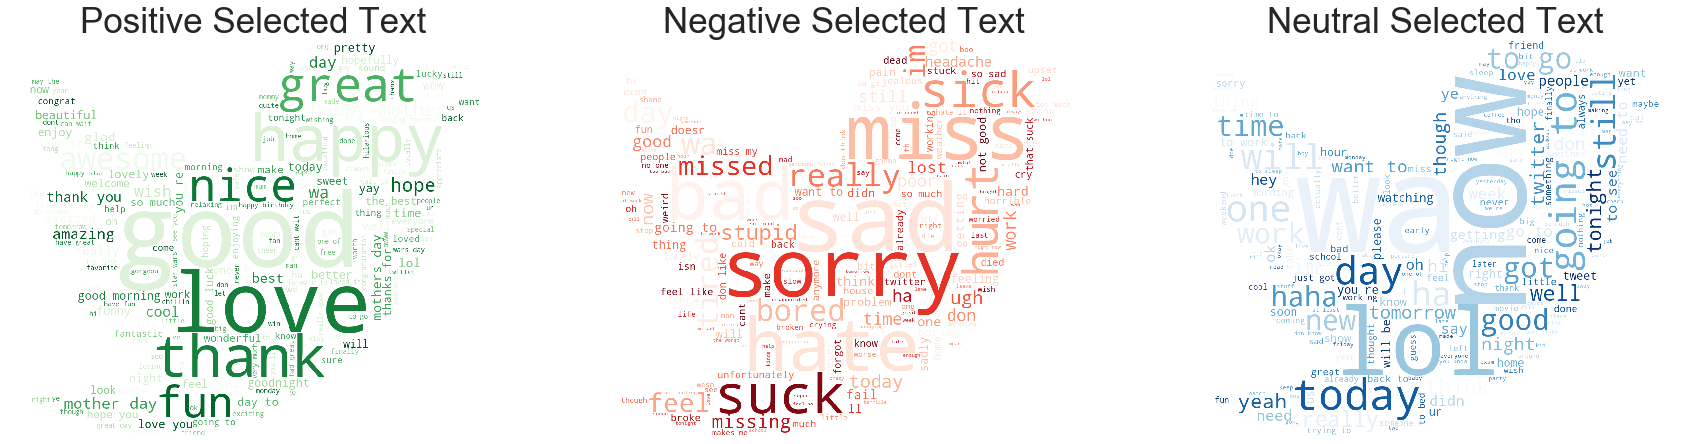

In [42]:
d = 'D:/ALY6020 81941 Predictive Analytics SEC 03 Spring 2020 CPS [VTC-B-HY] ALY6020.81941.202035/Project/'
bird = np.array(Image.open(d + 'twitterMask.png'))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])
wordcloud1 = WordCloud( background_color='white',mask=bird,colormap="Greens",
                        width=600,
                        height=400).generate(" ".join(tweet_train_word.loc[tweet_train_word['sentiment']=="positive"]['target']))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Selected Text',fontsize=35);

wordcloud2 = WordCloud( background_color='white',mask=bird,colormap="Reds",
                        width=600,
                        height=400).generate(" ".join(tweet_train_word.loc[tweet_train_word['sentiment']=="negative"]['target']))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Selected Text',fontsize=35);

wordcloud3 = WordCloud( background_color='white',mask=bird,colormap="Blues",
                        width=600,
                        height=400).generate(" ".join(tweet_train_word.loc[tweet_train_word['sentiment']=="neutral"]['target']))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral Selected Text',fontsize=35);


Let's add a column to the tweet_train dataset that will show the number of words in the text column

In [19]:
#Number Of words in main Text in train set

tweet_train['Num_words_text'] = tweet_train['text'].apply(lambda x:len(str(x).split())) 

In [20]:
tweet_train

textID                                               text  \
0      cb774db0d1                I`d have responded, if I were going   
1      549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2      088c60f138                          my boss is bullying me...   
3      9642c003ef                     what interview! leave me alone   
4      358bd9e861   Sons of ****, why couldn`t they put them on t...   
...           ...                                                ...   
27476  4eac33d1c0   wish we could come see u on Denver  husband l...   
27477  4f4c4fc327   I`ve wondered about rake to.  The client has ...   
27478  f67aae2310   Yay good for both of you. Enjoy the break - y...   
27479  ed167662a5                         But it was worth it  ****.   
27480  6f7127d9d7     All this flirting going on - The ATG smiles...   

                                           selected_text sentiment  \
0                    I`d have responded, if I were going   neutral   
1                                               Sooo SAD  negative   
2                                            bullying me  negative   
3                                         leave me alone  negative   
4                                          Sons of ****,  negative   
...                                                  ...       ...   
27476                                             d lost  negative   
27477                                      , don`t force  negative   
27478                          Yay good for both of you.  positive   
27479                         But it was worth it  ****.  positive   
27480  All this flirting going on - The ATG smiles. Y...   neutral   

       Num_words_text  
0                   7  
1                  10  
2                   5  
3                   5  
4                  14  
...               ...  
27476              16  
27477              23  
27478              22  
27479               6  
27480              11  

[27480 rows x 5 columns]

In [21]:
# splitting the tweet_train dataset into train test in order to have validation set

train_df, test_df = train_test_split(tweet_train, test_size=0.2, random_state=0)

In [22]:
train_df

textID                                               text  \
24567  a5ca70509c  Cant stop playin` in my head  -- pussycat doll...   
24619  f18b75e863                                         I hate you   
19766  649e31adcc                            Starbucks I`m lovin` it   
21737  8891d08a8c                         Ben and Jerry...yummmmy!!!   
8980   7fb24b4a56          wow.. purple leopard skin.  fieeerrceee..   
...           ...                                                ...   
13124  e68247e3f8   ...thanks for the shout out...you might be ri...   
19649  b250e64704    Im going in now, it looks like the sun has gone   
9846   84e69a3f34  I am soooo saying this phrase now 'Stop be so ...   
10800  5b34b39a42          Morning all  and its a lovely day at last   
2733   baeb1065cc  Editors read this and nod, writers read this a...   

                                           selected_text sentiment  \
24567  Cant stop playin` in my head  -- pussycat doll...   neutral   
24619                                         I hate you  negative   
19766                            Starbucks I`m lovin` it  positive   
21737                                          .yummmmy!  positive   
8980           wow.. purple leopard skin.  fieeerrceee..   neutral   
...                                                  ...       ...   
13124                                            .thanks  positive   
19649    Im going in now, it looks like the sun has gone   neutral   
9846   I am soooo saying this phrase now 'Stop be so ...   neutral   
10800                                         lovely day  positive   
2733   Editors read this and nod, writers read this a...   neutral   

       Num_words_text  
24567              15  
24619               3  
19766               4  
21737               3  
8980                5  
...               ...  
13124              14  
19649              11  
9846               22  
10800               9  
2733               12  

[21984 rows x 5 columns]

In [23]:
test_df

textID                                               text  \
20673  3391184efc              loves the nice weather and 7:30 exams   
12581  b35daf9677  Okay, this weather isn`t 'cute sundress' frien...   
13136  06e5249859                          Woo hoo!! Congratulations   
14013  3cd4960670   thanks   got a hold of someone there who knew...   
25030  92b75314ca  Got back and putting in the laundry. We got in...   
...           ...                                                ...   
10340  25cf98f210          Not feeling comfortable with myself today   
3867   55c4fea474                      And it`s starting to get cold   
9813   6baa2b379f  _Pritchard how come i dont see more of u? how ...   
16998  c0b19d85bd  _a_hart ah.. Birmingham! I remember being ther...   
22484  a830e774a5                                  indeed, much fail   

                                           selected_text sentiment  \
20673                                              loves  positive   
12581  Okay, this weather isn`t 'cute sundress' frien...   neutral   
13136                                    Congratulations  positive   
14013                                             thanks  positive   
25030  Got back and putting in the laundry. We got in...   neutral   
...                                                  ...       ...   
10340                            Not feeling comfortable  negative   
3867                       And it`s starting to get cold   neutral   
9813                                              im sad  negative   
16998  _a_hart ah.. Birmingham! I remember being ther...   neutral   
22484                                               fail  negative   

       Num_words_text  
20673               7  
12581              25  
13136               3  
14013              12  
25030              20  
...               ...  
10340               6  
3867                6  
9813               29  
16998              11  
22484               3  

[5496 rows x 5 columns]

### Model Formation

<p> &emsp;&emsp; We will be building three models for each of the three sentiments so that they are better able to identify the specific sentiments they are trained for. We will be defining a function called "training" which will accept 4 parameters as input and return a model via making a call to another function called "saving_model". The first parameter to the "training" function will be the train data that has to be provided in a JSON format as SpaCy only works with JSON files.The second parameter is the model's directory if we have an existing model that we want to retrain. The third parameter is the number of iterations that we want to perform with the training dataset, which is set to 10 by default. Finally, the 4th parameter is "model", which is by default set to None. However, if we have an existing model that we want to retrain, then we will be passing "nlp" as the input for this parameter. </p>

<p> &emsp;&emsp; Based on the parameters, the "training" function proceeds with either loading an existing model or creating a new blank language class where it then creates the pipeline component "ner" built-in in SpaCy using the method nlp.create_pipe(). Then it adds this component to the pipeline and disabled any other pipelines if existing, as we only want to use "NER" pipeline from SpaCy that houses multiple other pipeline components as well. Then we begin the training of this SpaCy model using nlp.begin_training() method or resume the training using nlp.resume_training() method if retraining an existing model. Then we enter a loop, where for every iteration, we reshuffle the training dataset randomly, provide their batch size and use nlp.update() method to update the model with new texts and annotations, and provide a 50% dropout rate so that the model doesn't memorize the training set and keeps dropping half the feautures it is learning to keep it generalized as shown below. </p>

In [25]:
# Model parameter should be passed as nlp instead of none if we want to train an existing model 

def training(train_data, model_dir, n_iter=10, model=None):
    #Load the model, set up the pipeline and train the entity recognizer.
    
    if model is not None:
        nlp = spacy.load(model_dir)  # loading the existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")   # creating a blank Language class
        print("Created a blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
        
    # otherwise, get it so we can add labels
    
    else:
        ner = nlp.get_pipe("ner")
    
    # add labels
    
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes): 
        
        # only train NER
        # batch up the examples using spaCy's minibatch
        
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()

        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))    
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(
                    texts,  # batch of texts
                    annotations,  # batch of annotations
                    drop=0.5,   # discarding half of the features to avoid memorizing
                    losses=losses, 
                )
            
            print("Losses", losses)
    saving_model(model_dir, nlp, 'st_ner')

<p> &emsp;&emsp; The "training" function prints the iterative losses and then makes a final call to the saving_model function which accepts three inputs as the parameters which are the model directory, the trained model as nlp and the new name of the model that needs to be stored. The purpose of thise saving_model function is to create a new directory for saving the created model using makedirs() method of the os library if one doesn't exist already. Then it sets the new name for the model which was passed as nlp and saves the model to the created directory and prints the directory where the model has been saved. </p>

In [26]:
# Saving the model into a directory

def saving_model(model_dir, nlp, new_name):
    
    model_dir = f'../CreatedModels/{model_dir}'
    if model_dir is not None:        
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        nlp.meta["name"] = new_name
        nlp.to_disk(model_dir)
        print("Saved the model to", model_dir)

<p> &emsp;&emsp; The "training" function needs this model directory which was created by the saving_model function as per the specific sentiment, since there will three models that will be created and saved. To accomplish this, we will be creating a function called "get_model_path" that will return this exact path by matching the specific sentiment that will be provided to it as the input parameter. It consists of simple if else statements that returns the positive_model path if the sentiment is positive, negative_model path if the sentiment is negative, else neutral.  </p>

In [27]:
# To obtain the path of the model

def get_model_path(sentiment):
    model_path = None
    if sentiment == 'positive':
        model_path = 'models/positive_model'
    elif sentiment == 'negative':
        model_path = 'models/negative_model'
    else:
        model_path = 'models/neutral_model'
    return model_path
    

<p> &emsp;&emsp; The last function that we need to create is the get_train_data function that will convert the training pandas dataframe into a JSON format that is accepted by SpaCy so that it can be passed as a parameter to the main "training" function for training the model. This function also accepts the sentiment as the input parameter and matches the sentiment with each rows of the training dataframe as it iterates through all the rows and returns the text of those matching rows, along with the selected_text and its starting and ending position that get lableled as entities for named entity recognition as shown below. </p>

In [28]:
# to create the train data in SpaCy input data format

def get_train_data(sentiment):
    train_data = []
    for index, row in train_df.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

<p> &emsp;&emsp; Now that we are done creating all the necessary functions that we need to create and train the model, we can start calling these functions and train our model with the combination of different parameters. First, we will need to initialize these parameters. We will start with the sentiment as 'positive', followed by initializing the train_data parameter that makes a call to the get_train_data function to obtain the JSON format training data with labelled entities. Then we initialize the model_path parameter which will call the get_model_path function by passing the input parameter set as 'positive' in this case and retrieve the model path. After initializing the parameters, we make a call to the training function by passing the 4 parameters that it needs. Since no previous model exists as of this stage, the parameter model will be passed as None and the number of iterations have been kept as 3 to begin with, which will be increased further during retraining of the created models. </p>

In [125]:
sentiment = 'positive'

train_data = get_train_data(sentiment)
model_path = get_model_path(sentiment)

training(train_data, model_path, n_iter=3, model=None)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Created a blank 'en' model


 33%|████████████████████████████                                                        | 1/3 [00:47<01:35, 47.91s/it]

Losses {'ner': 27645.46842243115}


 67%|████████████████████████████████████████████████████████                            | 2/3 [01:35<00:47, 47.68s/it]

Losses {'ner': 25408.352223617174}


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:24<00:00, 48.01s/it]

Losses {'ner': 23983.570706084556}
Saved the model to ../CreatedModels/models/positive_model


<p> &emsp;&emsp; As we can see, the training function first created a blank 'en' model as the model parameter was passed as none. We can see the progress bar of each batch iterations because of the "tqdm" library. The function also prints the Losses at the end of each iteration. We will be seeing the 'ner' loss as our model consists of only the 'ner' pipeline, ignoring all other pipeline components that come built-in with SpaCy. As per SpaCy's documentation [2], training loss for named entity recognizer should decrease, but usually not to 0. We can observe this reduction of NER losses at the end of each of the 3 iterations. At the end, the function prints the directory where the model is saved, which in this case is a postive_model, hence saved by creating a directory using that name.  </p>

<p> &emsp;&emsp; Now we will continue with the sentiment as 'negative', followed by initializing the train_data parameter that makes a call to the get_train_data function and the model_path parameter which will call the get_model_path function by passing the input parameter set as 'negative' in this case and retrieve the model path. After initializing the parameters, we make a call to the training function by passing the 4 parameters that it needs. Since no previous model exists as of this stage, the parameter model will be passed as None and the number of iterations have been kept as 3 to begin with, which will be increased further during retraining of the created models. </p>

In [127]:
sentiment = 'negative'

train_data = get_train_data(sentiment)
model_path = get_model_path(sentiment)

training(train_data, model_path, n_iter=3, model=None)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Created a blank 'en' model


 33%|████████████████████████████                                                        | 1/3 [00:45<01:31, 45.78s/it]

Losses {'ner': 26405.945230919955}


 67%|████████████████████████████████████████████████████████                            | 2/3 [01:30<00:45, 45.53s/it]

Losses {'ner': 23544.749400252414}


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:20<00:00, 46.70s/it]

Losses {'ner': 22274.13833759595}
Saved the model to ../CreatedModels/models/negative_model


<p> &emsp;&emsp; As we can see, the training function first created a blank 'en' model as the model parameter was passed as none. As expected, we observe the reduction of NER losses at the end of each of the 3 iterations. At the end, the function prints the directory where the model is saved, which in this case is a negative_model, hence saved by creating a directory using that name.  </p>

In [128]:
sentiment = 'neutral'

train_data = get_train_data(sentiment)
model_path = get_model_path(sentiment)

training(train_data, model_path, n_iter=3, model=None)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Created a blank 'en' model


 33%|████████████████████████████                                                        | 1/3 [00:57<01:54, 57.28s/it]

Losses {'ner': 5961.3095626142485}


 67%|████████████████████████████████████████████████████████                            | 2/3 [01:58<00:58, 58.57s/it]

Losses {'ner': 4411.30778220392}


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:09<00:00, 63.25s/it]

Losses {'ner': 3882.2620183273616}
Saved the model to ../CreatedModels/models/neutral_model


<p> &emsp;&emsp; Again we can see, the training function first created a blank 'en' model as the model parameter was passed as none. As expected, we observe the reduction of NER losses at the end of each of the 3 iterations. At the end, the function prints the directory where the model is saved, which in this case is a neutral_model, hence saved by creating a directory using that name. One thing to observe here is that the losses of Neutral model is significantly lesser compared to the positive and negative models.  </p>

<p> &emsp;&emsp; Now that we have created a model for each of the three sentiments, we can retrieve the same model for retraining them with more number of iterations and subsequently reducing the NER losses to increase the model accuracy. As we can see below, the training function first loaded the created spacy english language model from the model_path. One thing to remember here is to intitialize nlp using spacy.load() function, otherwise passing nlp as the model parameter to the function will throw an error.</p>

In [42]:
sentiment = 'positive'

train_data = get_train_data(sentiment)
model_path = get_model_path(sentiment)
nlp = spacy.load(model_path)


training(train_data, model_path, n_iter=3, model=nlp)

Loaded model '<spacy.lang.en.English object at 0x0000020E23EC5648>'


 33%|███████████████████████████▋                                                       | 1/3 [01:44<03:28, 104.09s/it]

Losses {'ner': 23358.95048738151}


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:35<01:46, 106.19s/it]

Losses {'ner': 22606.5913288186}


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:36<00:00, 112.06s/it]

Losses {'ner': 21959.43264894563}
Saved the model to ../CreatedModels/models/positive_model


<p> &emsp;&emsp; As expected, we observe the reduction of NER losses at the end of each of the 3 iterations. We can compare these losses with the NER losses at the end of the previous Positive model training and observe that the loss reduction continued from the previous model, indicating that the more number of times we retrain the existing spaCy model, the more we can reduce the NER losses of that model </p>

In [43]:
sentiment = 'negative'

train_data = get_train_data(sentiment)
model_path = get_model_path(sentiment)
nlp = spacy.load(model_path)

training(train_data, model_path, n_iter=3, model=None)

Created a blank 'en' model


 33%|███████████████████████████▋                                                       | 1/3 [01:43<03:27, 103.85s/it]

Losses {'ner': 25750.2910126713}


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:26<01:43, 103.57s/it]

Losses {'ner': 23415.35909454868}


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:09<00:00, 103.01s/it]

Losses {'ner': 22320.338774252043}
Saved the model to ../CreatedModels/models/negative_model


<p> &emsp;&emsp; As expected, we observe the reduction of NER losses at the end of each of the 3 iterations. As the parameter of model was passed as none by mistake, the function ended up creating a new model and overwriting the existing model path with the newly created above model. Therefore, we should be careful while passing the parameters next time as training models consume some cpu time and passing the parameter as none can erase all that work. </p>

In [44]:
sentiment = 'neutral'

train_data = get_train_data(sentiment)
model_path = get_model_path(sentiment)
nlp = spacy.load(model_path)

training(train_data, model_path, n_iter=3, model=None)

Created a blank 'en' model


 33%|███████████████████████████▋                                                       | 1/3 [02:08<04:17, 128.54s/it]

Losses {'ner': 6048.396751194661}


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:24<02:10, 130.67s/it]

Losses {'ner': 4284.120966325503}


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:07<00:00, 142.34s/it]

Losses {'ner': 4236.384582934004}
Saved the model to ../CreatedModels/models/neutral_model


In [31]:
os.chdir('D:\ALY6020 81941 Predictive Analytics SEC 03 Spring 2020 CPS [VTC-B-HY] ALY6020.81941.202035\\CreatedModels')

<p> &emsp;&emsp; Now that we have all the models as needed, we can re-train them by increasing the number of iterations to 10 and observe the NER losses. As expected, we observe the reduction of NER losses at the end of each of the 10 iterations. We can compare these losses with the NER losses at the end of the previous Positive model training and observe that the loss reduction continued from the previous model, indicating that the more number of times we retrain the existing spaCy model, the more we can reduce the NER losses of that model. Similarly, we can re-train models for the other sentiments as well. </p>

In [32]:
sentiment = 'positive'

train_data = get_train_data(sentiment)
model_path = get_model_path(sentiment)
nlp = spacy.load(model_path)


training(train_data, model_path, n_iter=10, model=nlp)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Loaded model '<spacy.lang.en.English object at 0x000001E170EC6748>'


 10%|████████▎                                                                          | 1/10 [00:50<07:38, 50.97s/it]

Losses {'ner': 21835.548766178094}


 20%|████████████████▌                                                                  | 2/10 [01:41<06:46, 50.84s/it]

Losses {'ner': 21384.42050068175}


 30%|████████████████████████▉                                                          | 3/10 [02:36<06:05, 52.16s/it]

Losses {'ner': 20648.32052058124}


 40%|█████████████████████████████████▏                                                 | 4/10 [03:43<05:39, 56.50s/it]

Losses {'ner': 20234.000124029248}


 50%|█████████████████████████████████████████▌                                         | 5/10 [04:50<04:58, 59.65s/it]

Losses {'ner': 19702.945600982668}


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [05:56<04:06, 61.73s/it]

Losses {'ner': 19676.930292414298}


 70%|██████████████████████████████████████████████████████████                         | 7/10 [07:07<03:13, 64.43s/it]

Losses {'ner': 19083.005984128595}


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [08:21<02:14, 67.30s/it]

Losses {'ner': 18687.615819248258}


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [09:28<01:07, 67.11s/it]

Losses {'ner': 18730.720762016823}


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [10:36<00:00, 63.60s/it]

Losses {'ner': 19009.12210254896}
Saved the model to ../CreatedModels/models/positive_model


<p> &emsp;&emsp; Once again, the parameter was passsed as None for the negative model that ended by recreating and replacing the existing negative model. However, the number of iterations was increased to 20, so it conducted 20 iterations. As expected, we observe the reduction of NER losses at the end of each of the 20 iterations. </p>

In [33]:
sentiment = 'negative'

train_data = get_train_data(sentiment)
model_path = get_model_path(sentiment)
nlp = spacy.load(model_path)

training(train_data, model_path, n_iter=20, model=None)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Created a blank 'en' model


  5%|████▏                                                                              | 1/20 [00:48<15:25, 48.72s/it]

Losses {'ner': 26031.896447577972}


 10%|████████▎                                                                          | 2/20 [01:35<14:26, 48.13s/it]

Losses {'ner': 23371.13410393073}


 15%|████████████▍                                                                      | 3/20 [02:24<13:41, 48.35s/it]

Losses {'ner': 22004.038346290414}


 20%|████████████████▌                                                                  | 4/20 [03:13<12:58, 48.65s/it]

Losses {'ner': 21143.294878658002}


 25%|████████████████████▊                                                              | 5/20 [04:05<12:22, 49.49s/it]

Losses {'ner': 20211.204675799676}


 30%|████████████████████████▉                                                          | 6/20 [04:58<11:47, 50.53s/it]

Losses {'ner': 19478.25806966754}


 35%|█████████████████████████████                                                      | 7/20 [05:50<11:05, 51.19s/it]

Losses {'ner': 18667.946108647226}


 40%|█████████████████████████████████▏                                                 | 8/20 [06:49<10:40, 53.35s/it]

Losses {'ner': 18231.93518835207}


 45%|█████████████████████████████████████▎                                             | 9/20 [07:44<09:53, 53.95s/it]

Losses {'ner': 17542.957819234893}


 50%|█████████████████████████████████████████                                         | 10/20 [08:47<09:27, 56.72s/it]

Losses {'ner': 17556.168945324298}


 55%|█████████████████████████████████████████████                                     | 11/20 [09:53<08:53, 59.31s/it]

Losses {'ner': 16948.173100460106}


 60%|█████████████████████████████████████████████████▏                                | 12/20 [10:51<07:52, 59.11s/it]

Losses {'ner': 16927.019182518743}


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [11:57<07:08, 61.20s/it]

Losses {'ner': 16372.671567050707}


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [13:02<06:12, 62.14s/it]

Losses {'ner': 16226.834007916352}


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [14:08<05:16, 63.29s/it]

Losses {'ner': 16312.232595285932}


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [15:13<04:15, 63.81s/it]

Losses {'ner': 16113.655702704631}


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [16:20<03:14, 64.84s/it]

Losses {'ner': 15563.394718949523}


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [17:29<02:12, 66.07s/it]

Losses {'ner': 15168.09247352309}


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [18:40<01:07, 67.50s/it]

Losses {'ner': 15024.771807338253}


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [19:53<00:00, 59.66s/it]

Losses {'ner': 14827.116906075555}
Saved the model to ../CreatedModels/models/negative_model


<p> &emsp;&emsp; Now we re-train the existing neutral model by increasing the number of iterations to 20 and carefully passing the model parameter as nlp. As expected, we observe the reduction of NER losses at the end of each of the 20 iterations. We can compare these losses with the NER losses at the end of the previous neutral model training and observe that the loss reduction continued from the previous model, again indicating that the more number of times we retrain the existing spaCy model, the more we can reduce the NER losses of that model </p>

In [34]:
sentiment = 'neutral'

train_data = get_train_data(sentiment)
model_path = get_model_path(sentiment)
nlp = spacy.load(model_path)

training(train_data, model_path, n_iter=20, model=nlp)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Loaded model '<spacy.lang.en.English object at 0x000001E170EC9A48>'


  5%|████▏                                                                              | 1/20 [01:13<23:19, 73.67s/it]

Losses {'ner': 4247.715463609888}


 10%|████████▎                                                                          | 2/20 [02:21<21:36, 72.02s/it]

Losses {'ner': 3796.848848364804}


 15%|████████████▍                                                                      | 3/20 [03:31<20:11, 71.24s/it]

Losses {'ner': 3804.735595490634}


 20%|████████████████▌                                                                  | 4/20 [04:41<18:55, 70.99s/it]

Losses {'ner': 3571.116840093306}


 25%|████████████████████▊                                                              | 5/20 [05:49<17:31, 70.11s/it]

Losses {'ner': 3401.6649393213293}


 30%|████████████████████████▉                                                          | 6/20 [06:59<16:18, 69.86s/it]

Losses {'ner': 3366.557095946048}


 35%|█████████████████████████████                                                      | 7/20 [08:07<15:02, 69.41s/it]

Losses {'ner': 3268.9028973191716}


 40%|█████████████████████████████████▏                                                 | 8/20 [09:14<13:43, 68.60s/it]

Losses {'ner': 3036.6528489331863}


 45%|█████████████████████████████████████▎                                             | 9/20 [10:21<12:31, 68.28s/it]

Losses {'ner': 3211.9897701438413}


 50%|█████████████████████████████████████████                                         | 10/20 [11:27<11:15, 67.60s/it]

Losses {'ner': 3057.621445488335}


 55%|█████████████████████████████████████████████                                     | 11/20 [12:34<10:06, 67.40s/it]

Losses {'ner': 2902.5466096275672}


 60%|█████████████████████████████████████████████████▏                                | 12/20 [13:39<08:52, 66.61s/it]

Losses {'ner': 2994.2886255870662}


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [14:49<07:52, 67.55s/it]

Losses {'ner': 2862.5394880591034}


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [15:54<06:41, 66.87s/it]

Losses {'ner': 3026.02497659798}


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [16:59<05:32, 66.43s/it]

Losses {'ner': 2823.2935873324664}


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [18:08<04:28, 67.04s/it]

Losses {'ner': 2835.551987217589}


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [19:22<03:27, 69.09s/it]

Losses {'ner': 2716.1059276841142}


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [20:40<02:23, 71.98s/it]

Losses {'ner': 2678.5643008235384}


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [21:57<01:13, 73.26s/it]

Losses {'ner': 2714.3978323831793}


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [23:22<00:00, 70.13s/it]

Losses {'ner': 2571.3906460698618}
Saved the model to ../CreatedModels/models/neutral_model


<p> &emsp;&emsp; We again re-train the models by increasing the number of iterations to 20 and observe the NER losses. As expected, we observe the reduction of NER losses at the end of each of the 20 iterations. We can compare these losses with the NER losses at the end of the previous Positive model training and observe that the loss reduction continued from the previous model, once again indicating that the more number of times we retrain the existing spaCy model, the more we can reduce the NER losses of that model </p>

In [41]:
sentiment = 'positive'

train_data = get_train_data(sentiment)
model_path = get_model_path(sentiment)
nlp = spacy.load(model_path)


training(train_data, model_path, n_iter=20, model=nlp)

Loaded model '<spacy.lang.en.English object at 0x000001E1713BCC48>'


  5%|████▏                                                                              | 1/20 [01:02<19:44, 62.37s/it]

Losses {'ner': 18064.971992524795}


 10%|████████▎                                                                          | 2/20 [02:08<19:01, 63.43s/it]

Losses {'ner': 18022.354005195593}


 15%|████████████▍                                                                      | 3/20 [03:25<19:08, 67.55s/it]

Losses {'ner': 18008.589277351377}


 20%|████████████████▌                                                                  | 4/20 [04:39<18:29, 69.37s/it]

Losses {'ner': 17682.951020574517}


 25%|████████████████████▊                                                              | 5/20 [05:48<17:20, 69.38s/it]

Losses {'ner': 17464.83302006453}


 30%|████████████████████████▉                                                          | 6/20 [06:58<16:13, 69.50s/it]

Losses {'ner': 17163.79744928959}


 35%|█████████████████████████████                                                      | 7/20 [08:06<14:58, 69.13s/it]

Losses {'ner': 16917.57116402446}


 40%|█████████████████████████████████▏                                                 | 8/20 [09:15<13:50, 69.19s/it]

Losses {'ner': 16905.94978333581}


 45%|█████████████████████████████████████▎                                             | 9/20 [10:23<12:34, 68.59s/it]

Losses {'ner': 16729.498852744033}


 50%|█████████████████████████████████████████                                         | 10/20 [11:30<11:21, 68.15s/it]

Losses {'ner': 17024.936603210284}


 55%|█████████████████████████████████████████████                                     | 11/20 [12:39<10:17, 68.60s/it]

Losses {'ner': 16645.457472883256}


 60%|█████████████████████████████████████████████████▏                                | 12/20 [13:49<09:10, 68.80s/it]

Losses {'ner': 16562.93946282582}


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [14:59<08:04, 69.15s/it]

Losses {'ner': 16507.13333480408}


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [16:04<06:48, 68.07s/it]

Losses {'ner': 15953.381307174259}


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [17:15<05:45, 69.04s/it]

Losses {'ner': 15795.454468411088}


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [18:25<04:36, 69.11s/it]

Losses {'ner': 15982.069748615684}


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [19:35<03:28, 69.39s/it]

Losses {'ner': 15855.74737096697}


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [20:45<02:19, 69.54s/it]

Losses {'ner': 15840.124474673707}


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [21:57<01:10, 70.34s/it]

Losses {'ner': 15393.29102029135}


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [23:10<00:00, 69.52s/it]

Losses {'ner': 15527.164125801779}
Saved the model to ../CreatedModels/models/positive_model


In [42]:
sentiment = 'negative'

train_data = get_train_data(sentiment)
model_path = get_model_path(sentiment)
nlp = spacy.load(model_path)

training(train_data, model_path, n_iter=20, model=nlp)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Loaded model '<spacy.lang.en.English object at 0x000001E1714B5CC8>'


  5%|████▏                                                                              | 1/20 [01:07<21:14, 67.08s/it]

Losses {'ner': 14872.419197297666}


 10%|████████▎                                                                          | 2/20 [02:13<20:03, 66.85s/it]

Losses {'ner': 14488.50008416511}


 15%|████████████▍                                                                      | 3/20 [03:21<19:04, 67.31s/it]

Losses {'ner': 14636.26387933917}


 20%|████████████████▌                                                                  | 4/20 [04:32<18:14, 68.38s/it]

Losses {'ner': 14371.97149907251}


 25%|████████████████████▊                                                              | 5/20 [05:44<17:23, 69.55s/it]

Losses {'ner': 14136.11110098807}


 30%|████████████████████████▉                                                          | 6/20 [06:55<16:16, 69.76s/it]

Losses {'ner': 14210.609691494188}


 35%|█████████████████████████████                                                      | 7/20 [08:03<15:01, 69.34s/it]

Losses {'ner': 14289.207702778274}


 40%|█████████████████████████████████▏                                                 | 8/20 [09:06<13:29, 67.42s/it]

Losses {'ner': 13965.921275433251}


 45%|█████████████████████████████████████▎                                             | 9/20 [10:09<12:06, 66.01s/it]

Losses {'ner': 14034.86805054322}


 50%|█████████████████████████████████████████                                         | 10/20 [11:12<10:50, 65.05s/it]

Losses {'ner': 13577.023064012943}


 55%|█████████████████████████████████████████████                                     | 11/20 [12:14<09:39, 64.34s/it]

Losses {'ner': 13603.509376495176}


 60%|█████████████████████████████████████████████████▏                                | 12/20 [13:17<08:30, 63.87s/it]

Losses {'ner': 13451.698737955532}


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [14:20<07:25, 63.64s/it]

Losses {'ner': 13063.617996332283}


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [15:22<06:19, 63.20s/it]

Losses {'ner': 13099.564716835126}


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [16:25<05:15, 63.09s/it]

Losses {'ner': 12896.726650156457}


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [17:28<04:12, 63.10s/it]

Losses {'ner': 13223.539475757487}


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [18:32<03:09, 63.18s/it]

Losses {'ner': 12405.060209422638}


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [19:37<02:07, 63.73s/it]

Losses {'ner': 12853.849501218663}


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [20:42<01:04, 64.09s/it]

Losses {'ner': 12825.230882089085}


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [21:45<00:00, 65.28s/it]

Losses {'ner': 12606.965621392716}
Saved the model to ../CreatedModels/models/negative_model


In [43]:
sentiment = 'neutral'

train_data = get_train_data(sentiment)
model_path = get_model_path(sentiment)
nlp = spacy.load(model_path)

training(train_data, model_path, n_iter=20, model=nlp)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Loaded model '<spacy.lang.en.English object at 0x000001E17140CE08>'


  5%|████▏                                                                              | 1/20 [01:03<20:01, 63.26s/it]

Losses {'ner': 3089.039056536137}


 10%|████████▎                                                                          | 2/20 [02:10<19:21, 64.51s/it]

Losses {'ner': 2862.5098239323606}


 15%|████████████▍                                                                      | 3/20 [03:22<18:54, 66.75s/it]

Losses {'ner': 2647.744301127935}


 20%|████████████████▌                                                                  | 4/20 [04:35<18:16, 68.53s/it]

Losses {'ner': 2867.5314150079685}


 25%|████████████████████▊                                                              | 5/20 [05:47<17:23, 69.56s/it]

Losses {'ner': 2705.291506912172}


 30%|████████████████████████▉                                                          | 6/20 [06:59<16:24, 70.31s/it]

Losses {'ner': 2530.625732694786}


 35%|█████████████████████████████                                                      | 7/20 [08:08<15:09, 69.97s/it]

Losses {'ner': 2290.443563823225}


 40%|█████████████████████████████████▏                                                 | 8/20 [09:18<14:00, 70.05s/it]

Losses {'ner': 2511.05140510388}


 45%|█████████████████████████████████████▎                                             | 9/20 [10:31<13:00, 70.98s/it]

Losses {'ner': 2490.120097939206}


 50%|█████████████████████████████████████████                                         | 10/20 [11:45<11:55, 71.60s/it]

Losses {'ner': 2377.385132833426}


 55%|█████████████████████████████████████████████                                     | 11/20 [12:53<10:35, 70.62s/it]

Losses {'ner': 2274.9877672675757}


 60%|█████████████████████████████████████████████████▏                                | 12/20 [14:02<09:20, 70.07s/it]

Losses {'ner': 2444.4006874240877}


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [15:12<08:11, 70.26s/it]

Losses {'ner': 2322.5721543571303}


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [16:21<06:59, 69.90s/it]

Losses {'ner': 2360.900989067386}


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [17:32<05:49, 69.97s/it]

Losses {'ner': 2320.9809611152036}


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [18:41<04:39, 69.91s/it]

Losses {'ner': 2240.6292690891737}


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [19:57<03:34, 71.56s/it]

Losses {'ner': 2319.23592099206}


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [21:07<02:22, 71.07s/it]

Losses {'ner': 2302.62406797456}


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [22:16<01:10, 70.47s/it]

Losses {'ner': 2231.849868439076}


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [23:26<00:00, 70.31s/it]

Losses {'ner': 2309.4239328684425}
Saved the model to ../CreatedModels/models/neutral_model


<p> &emsp;&emsp; We will train each of the three models one final time with 20 iterations before making them predict the selected_text on our validation dataset. As expected, we observe the reduction of NER losses at the end of each of the 20 iterations. We can compare these losses with the NER losses at the end of the previous Positive model and observe that the loss reduction continued from the previous model, once again indicating that the more number of times we retrain the existing spaCy model, the more we can reduce the NER losses of that model </p>

In [50]:
sentiment = 'positive'

train_data = get_train_data(sentiment)
model_path = get_model_path(sentiment)
nlp = spacy.load(model_path)


training(train_data, model_path, n_iter=20, model=nlp)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Loaded model '<spacy.lang.en.English object at 0x000001E171404288>'


  5%|████▏                                                                              | 1/20 [01:02<19:45, 62.41s/it]

Losses {'ner': 15306.058931476771}


 10%|████████▎                                                                          | 2/20 [02:02<18:32, 61.81s/it]

Losses {'ner': 15197.810261902188}


 15%|████████████▍                                                                      | 3/20 [03:04<17:29, 61.73s/it]

Losses {'ner': 14895.423405676089}


 20%|████████████████▌                                                                  | 4/20 [04:07<16:32, 62.02s/it]

Losses {'ner': 14924.258591301532}


 25%|████████████████████▊                                                              | 5/20 [05:16<16:03, 64.23s/it]

Losses {'ner': 15129.179856653489}


 30%|████████████████████████▉                                                          | 6/20 [06:23<15:09, 64.98s/it]

Losses {'ner': 14600.845022455087}


 35%|█████████████████████████████                                                      | 7/20 [07:27<14:02, 64.80s/it]

Losses {'ner': 14865.22096253814}


 40%|█████████████████████████████████▏                                                 | 8/20 [08:31<12:56, 64.69s/it]

Losses {'ner': 14743.820169783248}


 45%|█████████████████████████████████████▎                                             | 9/20 [09:38<11:56, 65.13s/it]

Losses {'ner': 14549.815717205072}


 50%|█████████████████████████████████████████                                         | 10/20 [10:42<10:49, 64.93s/it]

Losses {'ner': 14401.535469976818}


 55%|█████████████████████████████████████████████                                     | 11/20 [11:46<09:42, 64.67s/it]

Losses {'ner': 14887.015566884831}


 60%|█████████████████████████████████████████████████▏                                | 12/20 [12:51<08:37, 64.73s/it]

Losses {'ner': 14225.534957831525}


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [13:56<07:34, 64.91s/it]

Losses {'ner': 14056.555084869873}


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [15:01<06:29, 64.96s/it]

Losses {'ner': 14210.305338192193}


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [16:06<05:24, 64.88s/it]

Losses {'ner': 13809.37992234207}


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [17:09<04:17, 64.34s/it]

Losses {'ner': 13957.040824804444}


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [18:13<03:12, 64.32s/it]

Losses {'ner': 13602.829332021163}


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [19:17<02:08, 64.10s/it]

Losses {'ner': 13657.815365096681}


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [20:22<01:04, 64.39s/it]

Losses {'ner': 13804.705326747939}


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [21:27<00:00, 64.39s/it]

Losses {'ner': 13317.079683775406}
Saved the model to ../CreatedModels/models/positive_model


In [52]:
sentiment = 'negative'

train_data = get_train_data(sentiment)
model_path = get_model_path(sentiment)
nlp = spacy.load(model_path)

training(train_data, model_path, n_iter=20, model=nlp)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Loaded model '<spacy.lang.en.English object at 0x000001E1005EBD48>'


  5%|████▏                                                                              | 1/20 [01:00<19:00, 60.03s/it]

Losses {'ner': 12391.07085546563}


 10%|████████▎                                                                          | 2/20 [01:57<17:48, 59.37s/it]

Losses {'ner': 12170.482818510136}


 15%|████████████▍                                                                      | 3/20 [02:56<16:44, 59.07s/it]

Losses {'ner': 12314.46434246867}


 20%|████████████████▌                                                                  | 4/20 [03:57<15:54, 59.65s/it]

Losses {'ner': 12046.096380401597}


 25%|████████████████████▊                                                              | 5/20 [05:01<15:15, 61.01s/it]

Losses {'ner': 12395.013235070135}


 30%|████████████████████████▉                                                          | 6/20 [06:04<14:20, 61.50s/it]

Losses {'ner': 11929.784147774177}


 35%|█████████████████████████████                                                      | 7/20 [07:07<13:28, 62.23s/it]

Losses {'ner': 11815.574141290386}


 40%|█████████████████████████████████▏                                                 | 8/20 [08:10<12:28, 62.42s/it]

Losses {'ner': 12156.511288790583}


 45%|█████████████████████████████████████▎                                             | 9/20 [09:15<11:32, 63.00s/it]

Losses {'ner': 11966.727600645623}


 50%|█████████████████████████████████████████                                         | 10/20 [10:21<10:40, 64.04s/it]

Losses {'ner': 11564.349984711474}


 55%|█████████████████████████████████████████████                                     | 11/20 [11:23<09:31, 63.50s/it]

Losses {'ner': 11805.72112436617}


 60%|█████████████████████████████████████████████████▏                                | 12/20 [12:26<08:24, 63.11s/it]

Losses {'ner': 11419.064214065935}


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [13:29<07:23, 63.31s/it]

Losses {'ner': 11612.956947571707}


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [14:33<06:19, 63.28s/it]

Losses {'ner': 11544.939005993403}


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [15:36<05:16, 63.21s/it]

Losses {'ner': 11745.785039139333}


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [16:39<04:13, 63.27s/it]

Losses {'ner': 11427.074257667835}


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [17:41<03:09, 63.03s/it]

Losses {'ner': 11138.148060497162}


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [18:44<02:05, 62.90s/it]

Losses {'ner': 11441.79331998753}


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [19:46<01:02, 62.64s/it]

Losses {'ner': 11193.626740558904}


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [20:49<00:00, 62.45s/it]

Losses {'ner': 11001.179038027669}
Saved the model to ../CreatedModels/models/negative_model


In [53]:
sentiment = 'neutral'

train_data = get_train_data(sentiment)
model_path = get_model_path(sentiment)
nlp = spacy.load(model_path)

training(train_data, model_path, n_iter=20, model=nlp)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Loaded model '<spacy.lang.en.English object at 0x000001E17154C1C8>'


  5%|████▏                                                                              | 1/20 [01:05<20:36, 65.06s/it]

Losses {'ner': 2455.2338095556274}


 10%|████████▎                                                                          | 2/20 [02:12<19:43, 65.74s/it]

Losses {'ner': 2546.839260768403}


 15%|████████████▍                                                                      | 3/20 [03:23<19:04, 67.30s/it]

Losses {'ner': 2264.3654094914546}


 20%|████████████████▌                                                                  | 4/20 [04:33<18:09, 68.08s/it]

Losses {'ner': 2427.047507108862}


 25%|████████████████████▊                                                              | 5/20 [05:43<17:09, 68.65s/it]

Losses {'ner': 2246.9005575327765}


 30%|████████████████████████▉                                                          | 6/20 [06:51<15:58, 68.45s/it]

Losses {'ner': 2318.714628382842}


 35%|█████████████████████████████                                                      | 7/20 [07:58<14:45, 68.09s/it]

Losses {'ner': 2093.965164703904}


 40%|█████████████████████████████████▏                                                 | 8/20 [09:07<13:40, 68.37s/it]

Losses {'ner': 2123.2569898073143}


 45%|█████████████████████████████████████▎                                             | 9/20 [10:16<12:34, 68.56s/it]

Losses {'ner': 2243.441199978851}


 50%|█████████████████████████████████████████                                         | 10/20 [11:26<11:28, 68.88s/it]

Losses {'ner': 2231.7727482442697}


 55%|█████████████████████████████████████████████                                     | 11/20 [12:34<10:18, 68.67s/it]

Losses {'ner': 2229.948486587565}


 60%|█████████████████████████████████████████████████▏                                | 12/20 [13:42<09:08, 68.54s/it]

Losses {'ner': 2157.7700259584144}


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [14:50<07:57, 68.28s/it]

Losses {'ner': 2042.9383727996033}


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [15:57<06:48, 68.12s/it]

Losses {'ner': 1916.6854341138073}


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [17:04<05:37, 67.52s/it]

Losses {'ner': 1929.6093426524321}


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [18:12<04:31, 67.79s/it]

Losses {'ner': 2053.509497670895}


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [19:19<03:22, 67.55s/it]

Losses {'ner': 1955.7751103313744}


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [20:26<02:14, 67.28s/it]

Losses {'ner': 1921.9668521761987}


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [21:33<01:07, 67.19s/it]

Losses {'ner': 2039.9814582364713}


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [22:40<00:00, 68.04s/it]

Losses {'ner': 1910.1724089533213}
Saved the model to ../CreatedModels/models/neutral_model


### Prediction

<p> &emsp;&emsp; Now that we are done training our models, we can create a function that will predict the selected_text based on the sentiment. For this purpose, we can create a function named "text_predict" that will accept the text and the model as input parameters and obtain an array of texts from that passed model and save it as doc, where each of the entities associated with the text can be iterated through and the start and end lengths of the texts can be obtained, which are then appended to the entity array and the selected text is obtained from those positiions of the entity array with the specific length and the selected text is then returned as shown below.

In [44]:
# To predict the selected text

def text_predict(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

<p> &emsp;&emsp; The "text_predict" function that we created will be called after matching through the specific sentiment that will be set. So we first initialize the selected_texts object as a blank list, followed by setting the path where all the three models are saved as shown below. After all the three models are loaded using spacy.load method, for each row in the validation set, which is the test_df we created earlier after the train test split, text will be set as the text of the row and using if else conditions, for each sentiment of the row, selected texts will be appended by calling the text_predict function for the specific sentiments which returns the selected text and that gets appended to the empty list which was initialized earlier. After iterating through all the indexes, around 5496 of rows in the test_df dataframe, we have now obtained selected_text for each of the rows which can then be saved in a new column named "new_selected_text" that is added to the test_df dataframe for comparison as shown below. </p>

In [54]:
selected_texts = []
path = 'D:/ALY6020 81941 Predictive Analytics SEC 03 Spring 2020 CPS [VTC-B-HY] ALY6020.81941.202035/CreatedModels/models/'

if path is not None:
    print("Loading Models  from ", path)
    positive_model = spacy.load(path + 'positive_model')
    negative_model = spacy.load(path + 'negative_model')
    neutral_model = spacy.load(path + 'neutral_model')
        
    for index, row in test_df.iterrows():
        text = row.text
        output_str = ""
        if row.sentiment == 'neutral':
            selected_texts.append(text_predict(text, neutral_model))
        elif row.sentiment == 'positive':
            selected_texts.append(text_predict(text, positive_model))
        else:
            selected_texts.append(text_predict(text, negative_model))
        
test_df['new_selected_text'] = selected_texts

Loading Models  from  D:/ALY6020 81941 Predictive Analytics SEC 03 Spring 2020 CPS [VTC-B-HY] ALY6020.81941.202035/CreatedModels/models/


<p> &emsp;&emsp; We can add another column to our test_df dataframe that will aid us in comparing whether the texts in "selected_text" column and the predicted texts at "new_selected_text" column are of exact match or not. This column will have boolean values of 'True', if every single characted in the "selected_text" column matches the predicted texts at "new_selected_text" column, otherwise it will be False if even a single character is different  </p>

In [46]:
# to add a column match? to show if selected text matches predicted selected text

test_df['Match?'] = np.where(test_df['selected_text'] == test_df['new_selected_text'], 'True', 'False')  
test_df

textID                                               text  \
20673  3391184efc              loves the nice weather and 7:30 exams   
12581  b35daf9677  Okay, this weather isn`t 'cute sundress' frien...   
13136  06e5249859                          Woo hoo!! Congratulations   
14013  3cd4960670   thanks   got a hold of someone there who knew...   
25030  92b75314ca  Got back and putting in the laundry. We got in...   
...           ...                                                ...   
10340  25cf98f210          Not feeling comfortable with myself today   
3867   55c4fea474                      And it`s starting to get cold   
9813   6baa2b379f  _Pritchard how come i dont see more of u? how ...   
16998  c0b19d85bd  _a_hart ah.. Birmingham! I remember being ther...   
22484  a830e774a5                                  indeed, much fail   

                                           selected_text sentiment  \
20673                                              loves  positive   
12581  Okay, this weather isn`t 'cute sundress' frien...   neutral   
13136                                    Congratulations  positive   
14013                                             thanks  positive   
25030  Got back and putting in the laundry. We got in...   neutral   
...                                                  ...       ...   
10340                            Not feeling comfortable  negative   
3867                       And it`s starting to get cold   neutral   
9813                                              im sad  negative   
16998  _a_hart ah.. Birmingham! I remember being ther...   neutral   
22484                                               fail  negative   

       Num_words_text                                  new_selected_text  \
20673               7              loves the nice weather and 7:30 exams   
12581              25  Okay, this weather isn`t 'cute sundress' frien...   
13136               3                          Woo hoo!! Congratulations   
14013              12                                             thanks   
25030              20  Got back and putting in the laundry. We got in...   
...               ...                                                ...   
10340               6                            Not feeling comfortable   
3867                6                      And it`s starting to get cold   
9813               29                                             im sad   
16998              11  _a_hart ah.. Birmingham! I remember being ther...   
22484               3                                               fail   

      Match?  
20673  False  
12581   True  
13136  False  
14013   True  
25030   True  
...      ...  
10340   True  
3867    True  
9813    True  
16998   True  
22484   True  

[5496 rows x 7 columns]

<p> &emsp;&emsp; We can visually examine the two columns and see the Match? column is true, only when every single character matches and it shows False otherwise. For example, in the third row above, we can see the match? as False as the predicted "new_selected_text is including the texts "woo hoo!!" which is absent in the selected_text column. Even though the model missed predicting this particular row as per the dataset, if we think about it, the words "woo hoo!!" do indicate a positive sentiment as no one says woo hoo!! while being upset or neutral in real life. Therefore, once can argue that our model did a pretty good job in genralizing, and some of the wrong results can be attributed to inaccurate selected_text entries provided in the training dataset.  </p>

<p> &emsp;&emsp; The previous results were obtained after the penultimate number of model trainings. After training the model again for the final time, we tried to predict the texts again to see if the reduced NER losses actually cause a more accurate prediction. From the results below, we do see that the previously False matches of 2 rows are now made correctly by the model, indicating the model learnt from the re-training and got better. In each of the 1st and 3 row, where the predicted text made an error in the previous result, the re-trained model gave correct predictions. In row one it correctly predicted the text "loves" as the text causing the positive sentiment and in third row, it learned to not include the words "woo hoo!!" and only include "Congratulations".  </p>

In [55]:
# to add a column match? to show if selected text matches predicted selected text

test_df['Match?'] = np.where(test_df['selected_text'] == test_df['new_selected_text'], 'True', 'False')  
test_df

textID                                               text  \
20673  3391184efc              loves the nice weather and 7:30 exams   
12581  b35daf9677  Okay, this weather isn`t 'cute sundress' frien...   
13136  06e5249859                          Woo hoo!! Congratulations   
14013  3cd4960670   thanks   got a hold of someone there who knew...   
25030  92b75314ca  Got back and putting in the laundry. We got in...   
...           ...                                                ...   
10340  25cf98f210          Not feeling comfortable with myself today   
3867   55c4fea474                      And it`s starting to get cold   
9813   6baa2b379f  _Pritchard how come i dont see more of u? how ...   
16998  c0b19d85bd  _a_hart ah.. Birmingham! I remember being ther...   
22484  a830e774a5                                  indeed, much fail   

                                           selected_text sentiment  \
20673                                              loves  positive   
12581  Okay, this weather isn`t 'cute sundress' frien...   neutral   
13136                                    Congratulations  positive   
14013                                             thanks  positive   
25030  Got back and putting in the laundry. We got in...   neutral   
...                                                  ...       ...   
10340                            Not feeling comfortable  negative   
3867                       And it`s starting to get cold   neutral   
9813                                              im sad  negative   
16998  _a_hart ah.. Birmingham! I remember being ther...   neutral   
22484                                               fail  negative   

       Num_words_text                                  new_selected_text  \
20673               7                                              loves   
12581              25  Okay, this weather isn`t 'cute sundress' frien...   
13136               3                                    Congratulations   
14013              12                                             thanks   
25030              20  Got back and putting in the laundry. We got in...   
...               ...                                                ...   
10340               6                            Not feeling comfortable   
3867                6                      And it`s starting to get cold   
9813               29                                             im sad   
16998              11  _a_hart ah.. Birmingham! I remember being ther...   
22484               3                                               fail   

      Match?  
20673   True  
12581   True  
13136   True  
14013   True  
25030   True  
...      ...  
10340   True  
3867    True  
9813    True  
16998   True  
22484   True  

[5496 rows x 7 columns]

<p> &emsp;&emsp; Since we cannot manually check results of each of the 5496 rows of the test_df dataframe, we can create a boolean object that will store the true false values and then calculate, how many true predictions were made out of the 5496 rows of the validation dataset. We will use the boolean object name as total_bet and then save its sum in true_values object to obtain the number of true values as shown below. </p>

In [58]:
total_bet = test_df['selected_text'] == test_df['new_selected_text']
print(total_bet)

20673    True
12581    True
13136    True
14013    True
25030    True
         ... 
10340    True
3867     True
9813     True
16998    True
22484    True
Length: 5496, dtype: bool


In [48]:
true_values = sum(total_bet)
true_values

2864

<p> &emsp;&emsp; We find 2864 True values that shows the model accurately predicted over 52% of selected texts in rows with the precision of 100% as not even a character difference was accepted to be "True" in the results, no matter how close the "new_selected_text" got to the "selected_text". If we think about it, this way of measuring the accuracy of textual data seems vary harsh and unfair to the model's great work, therefore, we can calculate the Jaccard Similarity scores of the texts in these two columns and look at the average jaccard score as the accuracy metric of the model. </p>

<p> &emsp;&emsp; For this purpose, we will create a function called jaccard_similarity_score and pass the two strings of texts from the two columns as the input parameters. We will then use lower() and split() methods to convert the two input texts in lower case and also split them into individual words respectively. We will then compute the common words between the two using intersection() method and use the Jaccard similarity score formula [3] to compute the similarity score and return the same.   </p>
<p> &emsp;&emsp; We will then load the models again from their respective paths and inititalize the jaccard score as 0. Then we will loop for each row in the test_df validation set, we will obtain the text as selected text andfor each sentiment, call the jaccard_similarity_score function to obtain the score which will be printed at the end by dividing with the total number of rows in test_df to obtain the average jaccard score.  </p>

In [62]:
def jaccard_similarity_score(text1, text2): 
    tex1 = set(text1.lower().split()) 
    tex2 = set(text2.lower().split())
    common = tex1.intersection(tex2)
    return float(len(common)) / (len(tex1) + len(tex2) - len(common))


if path is not None:
    print("Loading Models  from ", path)
    positive_model = spacy.load(path + 'positive_model')
    negative_model = spacy.load(path + 'negative_model')
    neutral_model = spacy.load(path + 'neutral_model')
    
   # initialize the jaccard score as 0     
    jaccard_score = 0
    for index, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
        text = row.selected_text
        if row.sentiment == 'negative':
            jaccard_score += jaccard_similarity_score(text_predict(text, negative_model), row.new_selected_text)
        elif row.sentiment == 'positive':
            jaccard_score += jaccard_similarity_score(text_predict(text, positive_model), row.new_selected_text)
        else:
            jaccard_score += jaccard_similarity_score(text_predict(text, neutral_model), row.new_selected_text) 
        
    print(f'The Average Jaccard Score is {jaccard_score / test_df.shape[0]}')

Loading Models  from  D:/ALY6020 81941 Predictive Analytics SEC 03 Spring 2020 CPS [VTC-B-HY] ALY6020.81941.202035/CreatedModels/models/


100%|█████████████████████████████████████████████████████████████████████████████| 5496/5496 [00:11<00:00, 482.16it/s]

The Average Jaccard Score is 0.739393632866907


<p> &emsp;&emsp; We can see that the obtained average Jaccard score is 74%, which shows how similar our predicted "new_selected_text" rows have been to the "selected_text" rows, which seems like a fair evaluation of our models and shows a very good performance by them.  </p>

### Conclusion

<p> &emsp;&emsp; We can conclude that SpaCy's NER models are very effective in predicting textual data with high precision and good accuracy. These models can be further improved by re-training many number of times that effectively keeps reducing the NER losses and makes the models for efficient in prediction. By increasing the number of iterations and the number of re-training, the models can be made more accurate and they can be more generalized by increasing the drop out rates.  </p>

<p> &emsp;&emsp; With 74% of jaccard similarity and over 52% of exact predictions, we can conclude that the models did a great job in extracting the selected_text from the tweet text by seeing the label of sentiment of whether it is positive, negative or neutral. Creating three different models for these three different sentiments have helped the model to learn better and achieve better accuracy.  </p>

### References

[1] Training SpaCy’s NER Model. Retrieved from:
<br> https://spacy.io/usage/training#ner

[2] Training SpaCy’s Statistical Models. Retrieved from:
<br> https://spacy.io/usage/training

[3] Tweet Sentiment Extraction, extract support phrases for sentiment labels (featured Code competition)  Retrieved from:
<br> https://www.kaggle.com/c/tweet-sentiment-extraction/overview/description
